## Seattle Listing Data Cleaning

In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
pd.set_option("display.max.columns", None)
pd.set_option('min_rows', 10)
# pd.options.display.max_rows

### 1.1 Load the data

In [3]:
# read Seattle listing data, ignore 'access','interaction','house_rules' columns, set 'id' as index
df = pd.read_csv('seattle\listings.csv', sep=',', index_col='id', 
                 parse_dates=['last_scraped', 'host_since'], na_filter=True)

In [4]:
df.head(3)

,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,NaN,NaN,NaN,NaN,https://a1.muscache.com/ac/pictures/67560560/c...,NaN,956883,https://www.airbnb.com/users/show/956883,Maija,2011-08-11,"Seattle, Washington, United States","I am an artist, interior designer, and run a s...",within a few hours,96%,100%,f,https://a0.muscache.com/ac/users/956883/profil...,https://a0.muscache.com/ac/users/956883/profil...,Queen Anne,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Gilman Dr W, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.636289,-122.371025,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,$85.00,NaN,NaN,NaN,NaN,2,$5.00,1,365,4 weeks ago,t,14,41,71,346,2016-01-04,207,2011-11-01,2016-01-02,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,"Convenient bus stops are just down the block, ...",https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/im/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,5177328,https://www.airbnb.com/users/show/5177328,Andrea,2013-02-21,"Seattle, Washington, United States",Living east coast/left coast/overseas. Time i...,within an hour,98%,100%,t,https://a0.muscache.com/ac/users/5177328/profi...,https://a0.muscache.com/ac/users/5177328/profi...,Queen Anne,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t,"7th Avenue West, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.639123,-122.365666,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",NaN,$150.00,"$1,000.00","$3,000.00",$100.00,$40.00,1,$0.00,2,90,today,t,13,13,16,291,2016-01-04,43,2013-08-19,2015-12-29,96.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
3308979,

In [5]:
df.shape

(3818, 91)

### 1.2 Drop unnecessary columns
feat_info.csv was manually created and contains info about necessary property/actions to each column, such as id, numeric, categorical, location, drop, convert to numeric and convert to date etc.
It is worth mentioning why certain columns were dropped.
1. host_total_listings_count/calculated_host_listings_count: high correlation with host_listings_count
2. host_verifications: use host_identity_verified
3. zipcode: use neighbourhood_cleansed 
4. weekly_price/monthly_price: somewhat related to dependent variable or target daily 'price'. From an AirBnB home landlord's perspective, he/she is mostly like to set the daily 'price' first, before setting weekly_price/monthly_price charge.
5. number_of_reviews: use reviews_per_month

In [6]:
feat_info = pd.read_csv('feat_info.csv', sep=',')

# drop unnecessary columns
column_dropped_1 = feat_info[feat_info.action == 'drop']['name'].to_list()
df.drop(columns = column_dropped_1, axis=1, inplace = True)
df.shape

(3818, 43)

### 1.3 Convert data
'extra_people' is somewhat related to dependent variable or target 'price'. From a home landlord's perspective, he/she is mostly like to set the price first, before setting 'extra_people' charge. This means 'extra_people' can be ignored. However, 'extra_people' does affect the 'price' to some extend. To keep this effect, 0/1 dummy was used. The same applies to security_deposit' and 'cleaning_fee'.

In [7]:
# object to numeric
df['host_acceptance_rate'] = df['host_acceptance_rate'].str.replace('%', '').astype(float)/100
df['host_response_rate'] = df['host_response_rate'].str.replace('%', '').astype(float)/100
df['price'] = df['price'].replace('[$,]', '', regex=True).astype(float)
df['extra_people'] = df['extra_people'].replace('[$,]', '', regex=True).astype(float)

# convert to 0/1
df['extra_people'] = df['extra_people'].apply(lambda x: 1 if x>0 else 0)
# https://stackoverflow.com/questions/37543647/how-to-replace-all-non-nan-entries-of-a-dataframe-with-1-and-all-nan-with-0
df[['security_deposit', 'cleaning_fee']] = df[['security_deposit', 'cleaning_fee']].notnull().astype('int')

# calculate host days
df['host_days'] = (df['last_scraped'] - df['host_since']).dt.days

# convert calendar_updated to numeric days
calendar_updated_dict = {'today': 0, '2 weeks ago': 14, 'a week ago': 7, '3 weeks ago': 21, '2 months ago': 60, 'yesterday': 1, '4 weeks ago': 28, '3 months ago': 90, '4 days ago': 4, '5 weeks ago': 35, '3 days ago': 3, '5 days ago': 5, '4 months ago': 120, '6 weeks ago': 42, '2 days ago': 2, '5 months ago': 150, '7 weeks ago': 49, '7 months ago': 210, '6 days ago': 6, '1 week ago': 7, '6 months ago': 180, '8 months ago': 240, '10 months ago': 300, '9 months ago': 270, 'never': -1, '11 months ago': 330, '13 months ago': 390, '14 months ago': 420, '12 months ago': 360, '17 months ago': 510, '15 months ago': 450, '16 months ago': 480, '22 months ago': 660, '18 months ago': 540, '25 months ago': 750, '30 months ago': 900, '20 months ago': 600, '23 months ago': 690} 
df.calendar_updated.replace(calendar_updated_dict, inplace=True)
df['calendar_updated'] = np.where(df['calendar_updated'] <0, df['host_days'], df['calendar_updated']).astype(int)
df.drop(columns=['last_scraped','host_since'], axis=1, inplace=True)

### 1.4 Drop outliers
From the histogram of our target variable 'price', it is easy to observe that 'price' has a wide range of values. 
The extreme values (outliers) may affect the predicting power of the final model. Thus, some rows with extreme values of 'price' will be deleted. 
From the plot, it seems $600 is a good cutoff point. A total of 18 rows were deleted.

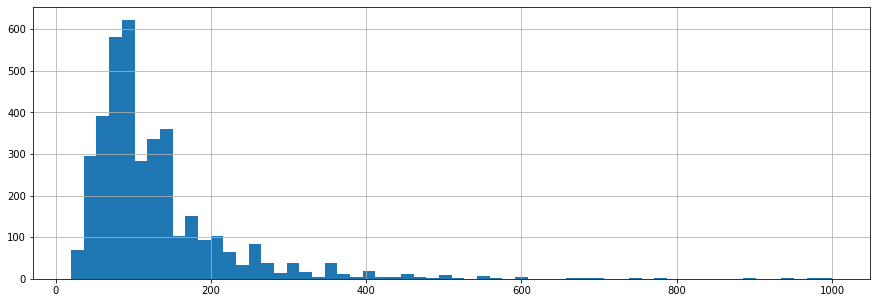

In [8]:
df.price.hist(figsize=(15, 5), bins=60)

In [9]:
df = df[df.price < 600]
df.shape

(3800, 42)

### 1.5 Drop rows with >30% data missing

Text(0.5, 0, '% percentage of missing columns for each row')

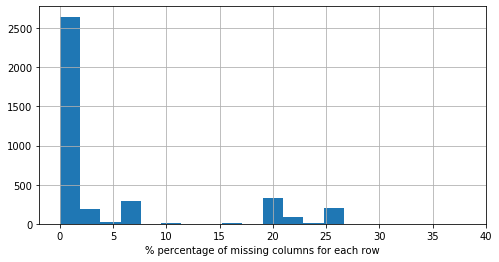

In [10]:
# missing data in each row
missing_row_ct = df.isnull().sum(axis = 1)
missing_row_ct.sort_values(ascending = False, inplace=True)
missing_row_pct = missing_row_ct/(df.shape[1]) * 100

# percentage of missing data in each row
missing_row_pct.hist(figsize=(8, 4), bins=20)
plt.xlabel('% percentage of missing columns for each row')

In [11]:
# delete rows with 30% more value missing, 2 rows deleted
df = df[df.isnull().sum(axis=1) < df.shape[1] * 0.3]
df.shape

(3798, 42)

### 1.6 Impute nulls in columns
The majority of columns have no missing values. For those having missing values, no single column has missing value than 25%. We will impute the nulls with mean or mode values. 

Text(0, 0.5, 'missing %')

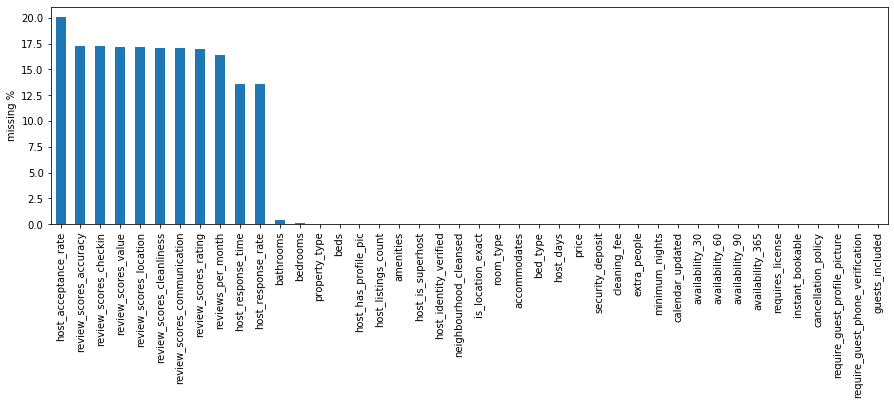

In [12]:
# missing data in each column
missing_ct = df.isnull().sum()
missing_ct.sort_values(ascending = False, inplace=True)
missing_pct = missing_ct/(df.shape[0]) * 100

# percentage of missing data in each column.
missing_pct.plot.bar(figsize=(15, 4))
plt.ylabel('missing %')

In [13]:
# fillna with mode for categorical columns, and the numeric columns that only take integer/fixed values
for col in ['host_response_time','property_type','bathrooms','bedrooms', 'beds']:
    df[col].fillna(df[col].mode().iloc[0], inplace=True)

In [14]:
# fillna with mean for numeric columns
df.fillna(df.mean(), inplace=True)

In [15]:
# double check there is no null values
df.isnull().mean()[df.isnull().mean() > 0].sort_values(ascending=False)

Series([], dtype: float64)

### 1.7 Convert 'amenities' to individual amenity

In [16]:
df['amenities'].replace(to_replace='[\{\}\"]', value='', regex=True, inplace=True)
amenities_dummy = df['amenities'].str.get_dummies(sep=',').add_prefix('amenity_')

# concatenate all individual amenities column with the full dataset
df = pd.concat([df, amenities_dummy], axis=1, sort=False)
df.drop(columns=['amenities'], inplace=True, axis=1)

In [17]:
# create a list of object columns
cols_cat = df.select_dtypes(include=[object]).columns.to_list()

### 1.8 One-hot encoding of categorical fetures

In [18]:
df = pd.get_dummies(data=df, prefix=cols_cat, prefix_sep='_', columns=cols_cat, drop_first=True)

### 1.9 Final review of the processed data

In [19]:
df.head()

,host_response_rate,host_acceptance_rate,host_listings_count,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,calendar_updated,availability_30,availability_60,availability_90,availability_365,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,host_days,amenity_24-Hour Check-in,amenity_Air Conditioning,amenity_Breakfast,amenity_Buzzer/Wireless Intercom,amenity_Cable TV,amenity_Carbon Monoxide Detector,amenity_Cat(s),amenity_Dog(s),amenity_Doorman,amenity_Dryer,amenity_Elevator in Building,amenity_Essentials,amenity_Family/Kid Friendly,amenity_Fire Extinguisher,amenity_First Aid Kit,amenity_Free Parking on Premises,amenity_Gym,amenity_Hair Dryer,amenity_Hangers,amenity_Heating,amenity_Hot Tub,amenity_Indoor Fireplace,amenity_Internet,amenity_Iron,amenity_Kitchen,amenity_Laptop Friendly Workspace,amenity_Lock on Bedroom Door,amenity_Other pet(s),amenity_Pets Allowed,amenity_Pets live on this property,amenity_Pool,amenity_Safety Card,amenity_Shampoo,amenity_Smoke Detector,amenity_Smoking Allowed,amenity_Suitable for Events,amenity_TV,amenity_Washer,amenity_Washer / Dryer,amenity_Wheelchair Accessible,amenity_Wireless Internet,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,host_is_superhost_t,host_has_profile_pic_t,host_identity_verified_t,neighbourhood_cleansed_Alki,neighbourhood_cleansed_Arbor Heights,neighbourhood_cleansed_Atlantic,neighbourhood_cleansed_Belltown,neighbourhood_cleansed_Bitter Lake,neighbourhood_cleansed_Briarcliff,neighbourhood_cleansed_Brighton,neighbourhood_cleansed_Broadview,neighbourhood_cleansed_Broadway,neighbourhood_cleansed_Bryant,neighbourhood_cleansed_Cedar Park,neighbourhood_cleansed_Central Business District,neighbourhood_cleansed_Columbia City,neighbourhood_cleansed_Crown Hill,neighbourhood_cleansed_Dunlap,neighbourhood_cleansed_East Queen Anne,neighbourhood_cleansed_Eastlake,neighbourhood_cleansed_Fairmount Park,neighbourhood_cleansed_Fauntleroy,neighbourhood_cleansed_First Hill,neighbourhood_cleansed_Fremont,neighbourhood_cleansed_Gatewood,neighbourhood_cleansed_Genesee,neighbourhood_cleansed_Georgetown,neighbourhood_cleansed_Green Lake,neighbourhood_cleansed_Greenwood,neighbourhood_cleansed_Haller Lake,neighbourhood_cleansed_Harrison/Denny-Blaine,neighbourhood_cleansed_High Point,neighbourhood_cleansed_Highland Park,neighbourhood_cleansed_Holly Park,neighbourhood_cleansed_Industrial District,neighbourhood_cleansed_Interbay,neighbourhood_cleansed_International District,neighbourhood_cleansed_Laurelhurst,neighbourhood_cleansed_Lawton Park,neighbourhood_cleansed_Leschi,neighbourhood_cleansed_Lower Queen Anne,neighbourhood_cleansed_Loyal Heights,neighbourhood_cleansed_Madison Park,neighbourhood_cleansed_Madrona,neighbourhood_cleansed_Mann,neighbourhood_cleansed_Maple Leaf,neighbourhood_cleansed_Matthews Beach,neighbourhood_cleansed_Meadowbrook,neighbourhood_cleansed_Mid-Beacon Hill,neighbourhood_cleansed_Minor,neighbourhood_cleansed_Montlake,neighbourhood_cleansed_Mount Baker,neighbourhood_cleansed_North Admiral,neighbourhood_cleansed_North Beach/Blue Ridge,neighbourhood_cleansed_North Beacon Hill,neighbourhood_cleansed_North College Park,neighbourhood_cleansed_North Delridge,neighbourhood_cleansed_North Queen Anne,neighbourhood_cleansed_Olympic Hills,neighbourhood_cleansed_Phinney Ridge,neighbourhood_cleansed_Pike-Market,neighbourhood_cleansed_Pinehurst,neighbourhood_cleansed_Pioneer Square,neighbourhood_cleansed_Portage Bay,neighbourhood_cleansed_Rainier Beach,neighbourhood_cleansed_Ravenna,neighbourhood_cleansed_Riverview,neighbourhood_cleansed_Roosevelt,neighbourhood_cleansed_Roxhill,neighbourhood_cleansed_Seaview,neighbourhood_cleansed_Seward Park,neighbourhood_cleansed_South Beacon Hill,neighbourhood_cleansed_South Delridge,neighbourhood_cleans

In [20]:
df.shape

(3798, 187)

### 1.10 Save the processed data to local file

In [21]:
df.to_csv('results\df_listings_seattle.csv')